In [117]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action="ignore", category=DataConversionWarning)
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)


plt.rcParams['figure.figsize'] = (10, 4)

#import scikit-learn libraries
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import GridSearchCV

In [38]:
df = pd.read_excel("mobilesales.xlsx", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2001-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   198 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


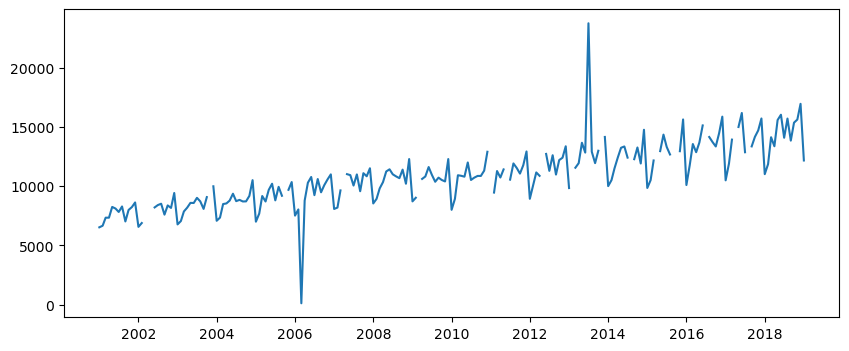

In [39]:
plt.plot(df["Sales"])
plt.show()

We can see that the data starts form "2001-01-01" to "2019-01-01"

We can see there are 19 missing values in the data. We need to impute the Data for the missing values

We can use the following techniques:
- mean/Median Imputation
- KNN Imputation
- fillNa function
- linear Imputation

# Data Imputation

## Mean/Median Imputation

In [40]:
# Plot Both graphs

def plotImputatedGraphs(before, after):
    plt.plot(after["Sales"], label="Imputed")
    plt.plot(before["Sales"], label="Original")
    plt.axhline(y=before["Sales"].mean(), linestyle=":", color="green")
    plt.legend()
    plt.show()

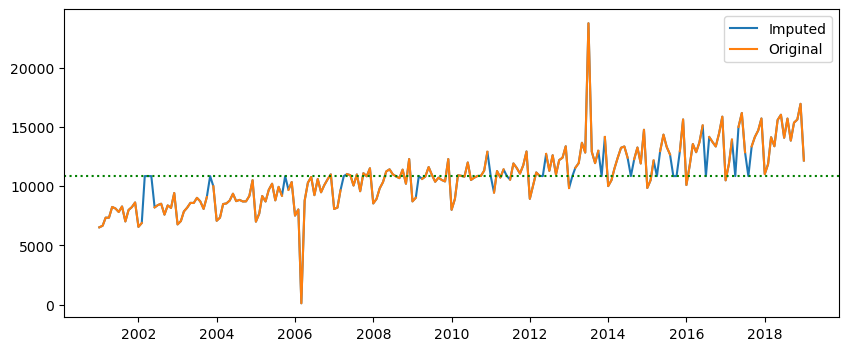

In [41]:
# Mean/Median Imputation
df_mean = df.copy()
df_mean = df_mean.fillna(value=df_mean["Sales"].mean())
plotImputatedGraphs(before=df, after=df_mean)

Not the best way to impute the data. 

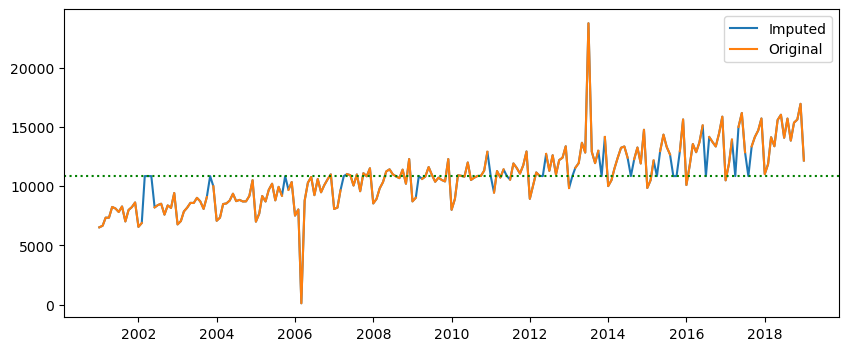

In [42]:
# same as Mean imputation but using Scikit learn

df_SI = df.copy()
simpImp = SimpleImputer(strategy="mean")
df_SI = pd.DataFrame(simpImp.fit_transform(df_SI), columns=simpImp.get_feature_names_out(), index=df_SI.index)
plotImputatedGraphs(before=df, after=df_SI)

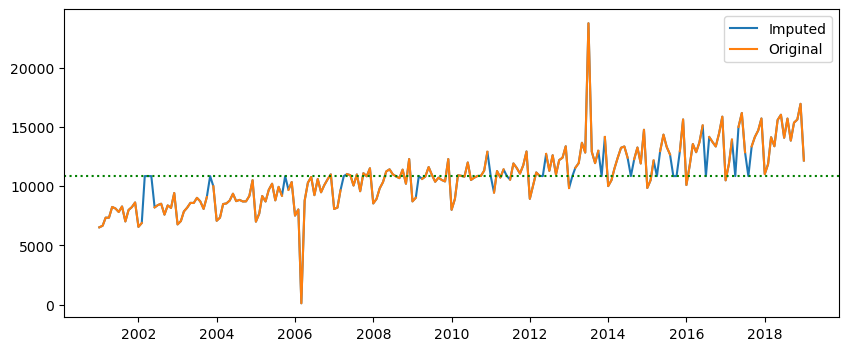

In [43]:
# KNN Imputation
knnImp = KNNImputer(n_neighbors=5)
df_KNN = pd.DataFrame(knnImp.fit_transform(df), columns=knnImp.get_feature_names_out(), index=df.index)
plotImputatedGraphs(before=df, after=df_KNN)

The filling looks exactly same as mean imputation

In [44]:
# forward Fill and Back Fill

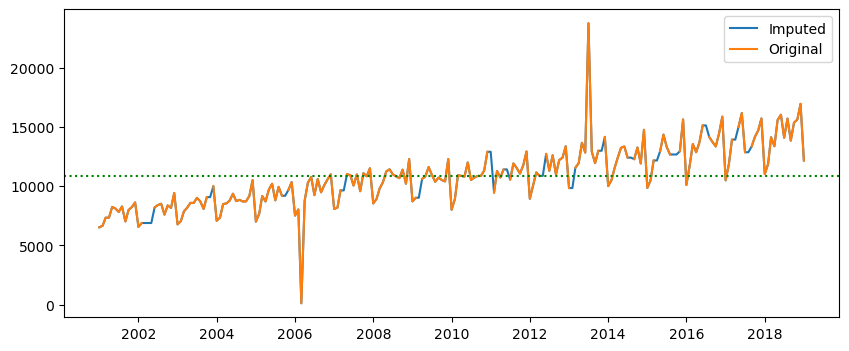

In [45]:
df_ff = df.copy()
df_ff["Sales"] = df["Sales"].fillna(method="ffill")
plotImputatedGraphs(before=df, after=df_ff)

Forward and backwords fill are soo much better than the mean/Median/KNN imputation

In [46]:
# linear imputation

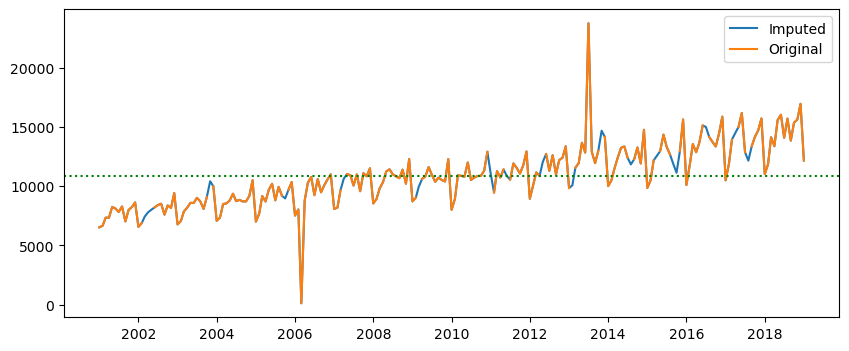

In [47]:
df_linInt = df.copy()
df_linInt["Sales"] = df["Sales"].interpolate(method="quadratic")
plotImputatedGraphs(before=df, after=df_linInt)

This imputation method is a lot better than the other imputation methods.

In [48]:
df["Sales"] = df["Sales"].interpolate(method="quadratic")

# Anamolies in the Data

We can see there are 2 anamolies in the data. We don't want our data to give wrong precitions because of the anamolies in the data.

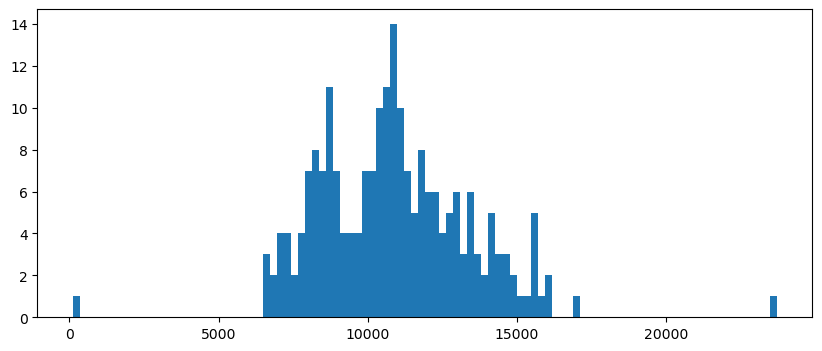

In [49]:
# cleaning anamolies in the data.

# We can clearly see 2 outliers in the Data
# We need to clip the data and later analize the reason for anamolies.
plt.hist(x=df["Sales"], bins=100)
plt.show()

In [50]:
df["Sales"].clip(lower=df["Sales"].quantile(0.01),
                 upper=df["Sales"].quantile(0.99), inplace=True)

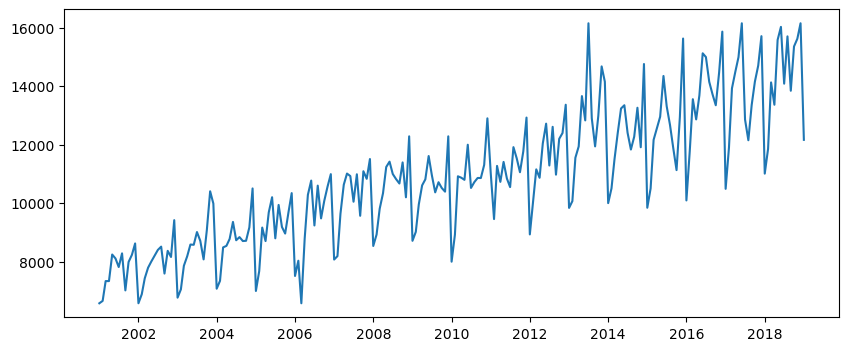

In [51]:
plt.plot(df["Sales"])
plt.show()

# ETS Decomposition

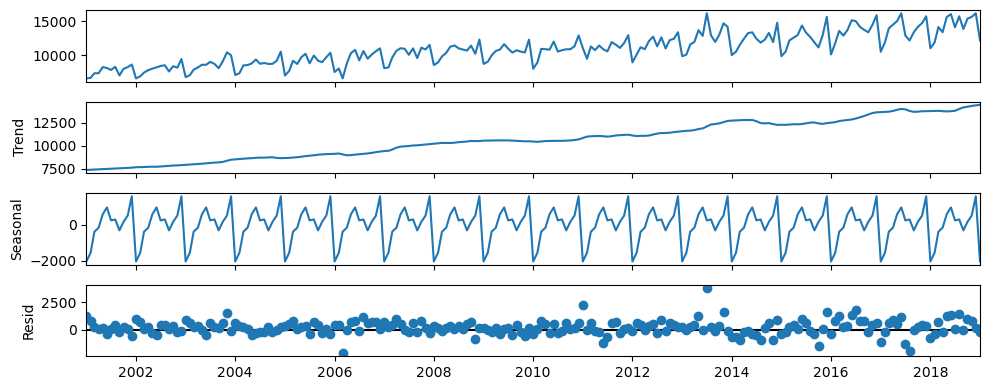

In [52]:
# one direct way to do the ETS decomposition is by using statsmodel

import statsmodels.api as sm_api

ets_model = sm_api.tsa.seasonal_decompose(df, model="additive", two_sided=False, extrapolate_trend=12)
ets_model.plot()
plt.show()

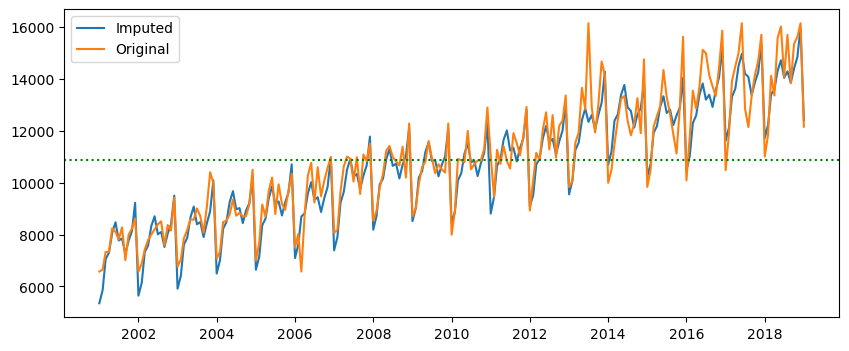

In [53]:
# trying to forecast the data using ETA

plotImputatedGraphs(before=df, after=pd.DataFrame(ets_model.trend + ets_model.seasonal, columns=["Sales"], index=df.index))

We can see that the Data is almost a perfect.

Limitations:
- Method is not for forecasting but for Understanding the Data.
- Sometimes the data has multiple trends and seasonalities, where this model failes
- No inbuild functions to forecast the data.

## Trend

We can get the Trend line of a data using the following methods.

We can use the window size as "Seasonality" value. Anything more than that will cause the Seasonality value to get added twice and lead to misleading values. Anything less is fine. As moving window size increases, the data starts to smoothen out, and the fluctuations in the data reduce

- Moving average

[]

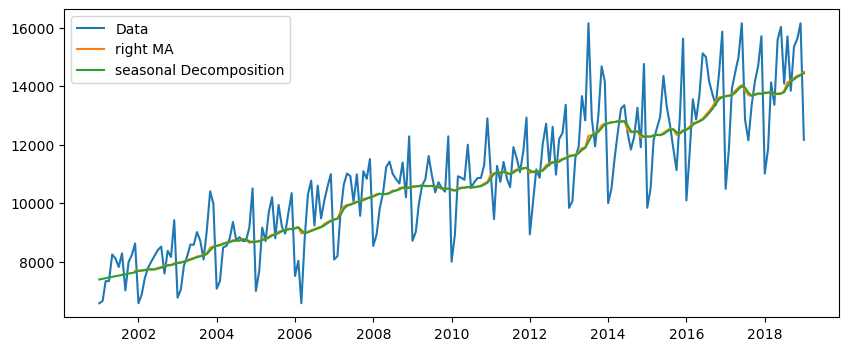

In [54]:
# moving average
df_decomp = df.copy()

df_decomp["trend"] = df.rolling(window=12, center=False).mean()
plt.plot(df, label="Data")
plt.plot(df_decomp["trend"], label="right MA")
plt.plot(ets_model.trend, label="seasonal Decomposition")
plt.legend()
plt.plot()


## We can see that the rigt moving average is lagging in change. ie, the changes are seen long after the actual dip in data. (right window)
## where as, the model from Seasonal Decomposition can be configured to center/right moving average by using two_sided parameter 

## Seasonality

[]

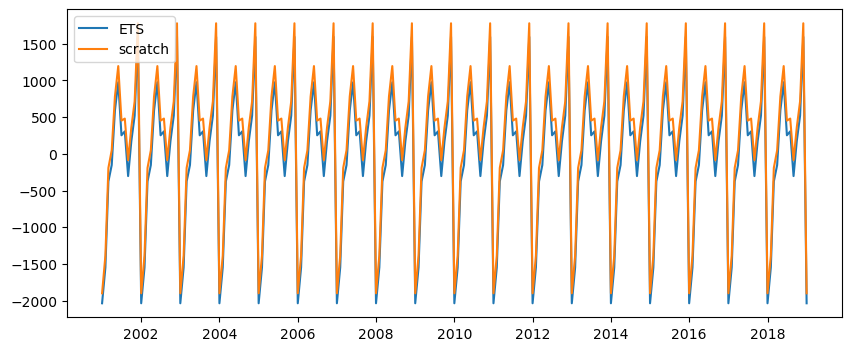

In [55]:
# seasonality can be calculated by averaging out data over seasonality Value
DeTrended = df_decomp["Sales"] - df_decomp["trend"]
df_decomp["Seasonality"] = DeTrended.groupby(by=df.index.month).transform("mean")

plt.plot(ets_model.seasonal, label="ETS")
plt.plot(df_decomp["Seasonality"], label="scratch")
plt.legend()
plt.plot()

## we ca see the data drom ETS model and out model are almost same.

# Forecast models

In [56]:
# Train Test Split

df.info()

print("\n")
# training Data has 205 datapoints.
# test Data has 12 Datapoints.

train = df.iloc[0:205]

print("\033[4mTRAIN TEST SPLIT:\033[0m")
print("size of train: ", train.shape)
test  = df.iloc[205:]
print("size of test: ", test.shape)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2001-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   217 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


TRAIN TEST SPLIT:
size of train:  (205, 1)
size of test:  (12, 1)


In [57]:
# evaluation functions

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
def eval_model(yVal, yPred):
    print("MAPE: ", np.round(mean_absolute_percentage_error(y_true=yVal, y_pred=yPred) * 100, 3))
    print("MAE:  ", np.round(mean_absolute_error(y_true=yVal, y_pred=yPred), 3))
    print("RMSE: ", np.round(root_mean_squared_error(y_true=yVal, y_pred=yPred), 3))

## Mean Forecast

TRAIN ACCURACY:
MAPE:  17.544
MAE:   1763.464
RMSE:  2195.113

TEST ACCURACY:
MAPE:  25.76
MAE:   3841.082
RMSE:  4094.343


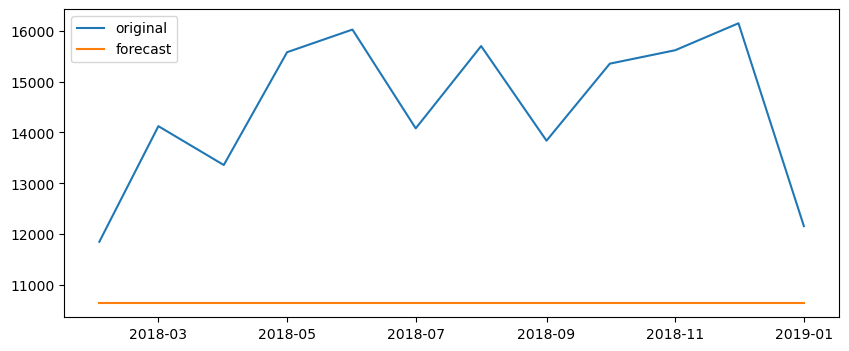

In [58]:
# the Forecast value will be the mean of the complete TS
train["pred"] = train["Sales"].mean()
test["pred"] = train["Sales"].mean()

# # train Accuracy
print("TRAIN ACCURACY:")
eval_model(yVal=train["Sales"], yPred=train["pred"])

print()

# # test Accuracy
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=test["pred"])

plt.plot(test["Sales"], label="original")
plt.plot(test["pred"], label="forecast")
plt.legend()
plt.show()

Testing accuracy is <span style="color:Green">**25.76%**</span> MAPE <br>
The accuracy is pretty bad. Needs improvement.

## Naive Forecast

TEST ACCURACY:
MAPE:  23.24
MAE:   3479.79
RMSE:  3757.483


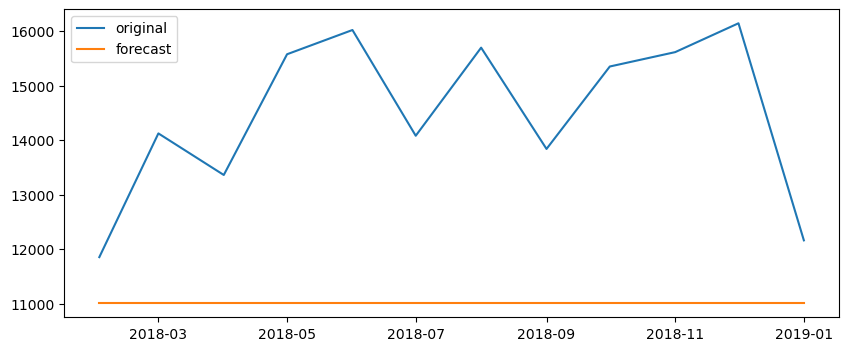

In [59]:
# the Forecast value will be the last data point.
test["pred"] = train["Sales"].iloc[-1]

# # test Accuracy
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=test["pred"])

plt.plot(test["Sales"], label="original")
plt.plot(test["pred"], label="forecast")
plt.legend()
plt.show()

Testing accuracy is <span style="color:Green">**23.24%**</span> MAPE <br>
The accuracy is pretty bad. Needs improvement.

## Seasonal Naive

In [60]:
# the Forecast value will be the last seasonal Value.

seasonality = 12
for i in range(test.shape[0]):
    trainIndex = i + (train.shape[0]) - seasonality
    test["pred"].iloc[i] = train.iloc[trainIndex]["Sales"]

# # test Accuracy
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=test["pred"])

TEST ACCURACY:
MAPE:  6.289
MAE:   920.97
RMSE:  1285.036


TEST ACCURACY:
MAPE:  6.289
MAE:   920.97
RMSE:  1285.036


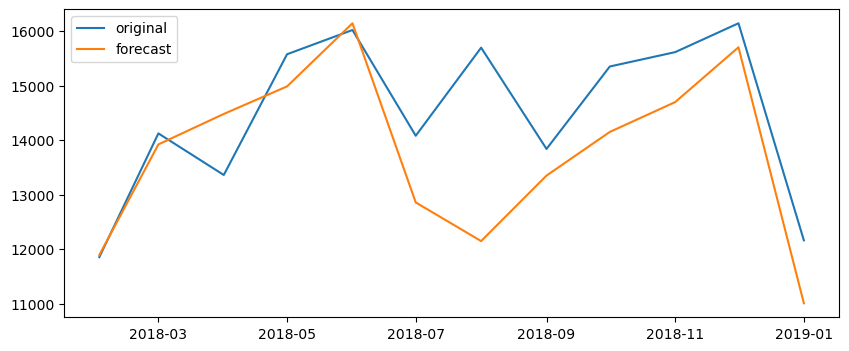

In [61]:
# method 2
test["pred"] = train.loc[test.index - pd.DateOffset(years=1), "Sales"].values

# # test Accuracy
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=test["pred"])

plt.plot(test["Sales"], label="original")
plt.plot(test["pred"], label="forecast")
plt.legend()
plt.show()

Testing accuracy is <span style="color:Green">**6.289%**</span> MAPE <br>
Its good. But, might not work always<br>
We can get all past seasonalities, that would make the model even better

## Drift method

TEST ACCURACY:
MAPE:  22.424
MAE:   3360.892
RMSE:  3640.673


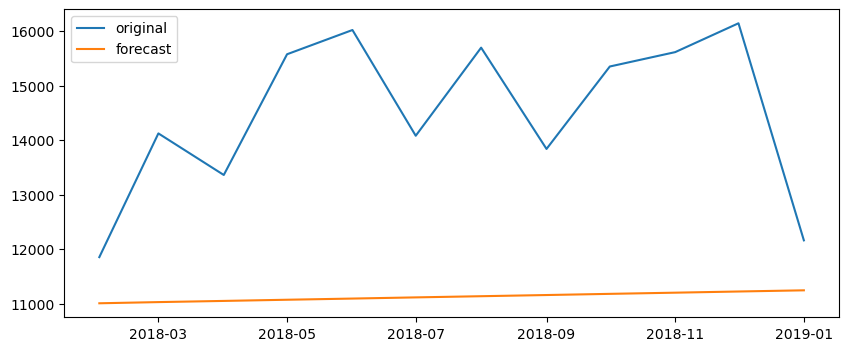

In [62]:
# use the first and last Data point to create a trendline and extrapolate it as prediction

slope = ((train["Sales"].iloc[-1] - train["Sales"].iloc[0])/train["Sales"].shape[0])

for index in range(test.shape[0]):
    test["pred"].iloc[index] = train["Sales"].iloc[-1] + (index * slope)

# # test Accuracy
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=test["pred"])

plt.plot(test["Sales"], label="original")
plt.plot(test["pred"], label="forecast")
plt.legend()
plt.show()

Testing accuracy is <span style="color:Green">**22.424%**</span> MAPE <br>
The accuracy is pretty bad. Needs improvement.

## Moving Average method

In [63]:
# Uses rolling window for the last training data and move the rolling window to test data.
# moving Average --> Only considers the most revent level.
# the prediction values fluctuate and settle over time

windowsize = 3
testMA = pd.concat([train.iloc[-1-windowsize:], pd.DataFrame(index=test.index)])
testMA.loc[~testMA["pred"].isna(), "pred"] = np.nan

pred = testMA["Sales"].dropna().values

for index in range(test.shape[0]):
    pred = np.append(pred, pred[-windowsize:].mean())

testMA["pred"] = pred
testMA.loc[testMA["Sales"].dropna().index, "pred"] = np.nan

MAPE:  11.732
MAE:   1738.024
RMSE:  1940.885


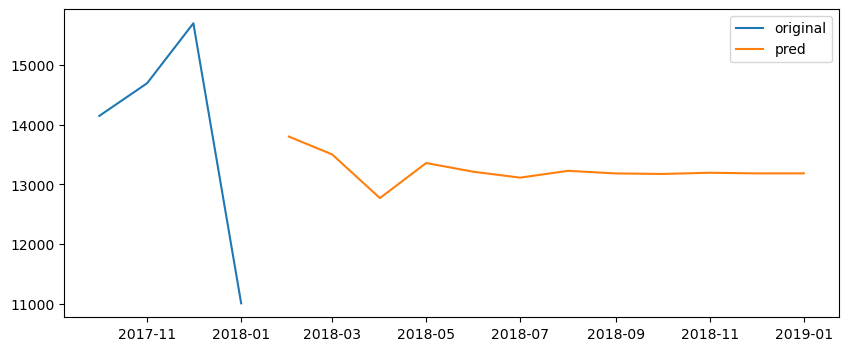

In [64]:
eval_model(yVal=test["Sales"], yPred=testMA.loc[~testMA["pred"].isna(), "pred"])

plt.plot(testMA["Sales"], label="original")
plt.plot(testMA["pred"], label="pred")
plt.legend()
plt.show()

Testing accuracy is <span style="color:Green">**11.73%**</span> MAPE <br>
The accuracy is bad. But can improvement.

In [65]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action="ignore", category=DataConversionWarning)
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)


Best MAPE: 0.09729414973809203, Best Smoothing Factor = 0.13636363636363635

TRAIN ACCURACY: 
MAPE:  9.138
MAE:   960.078
RMSE:  1235.1

TEST ACCURACY:
MAPE:  9.729
MAE:   1432.196
RMSE:  1646.268



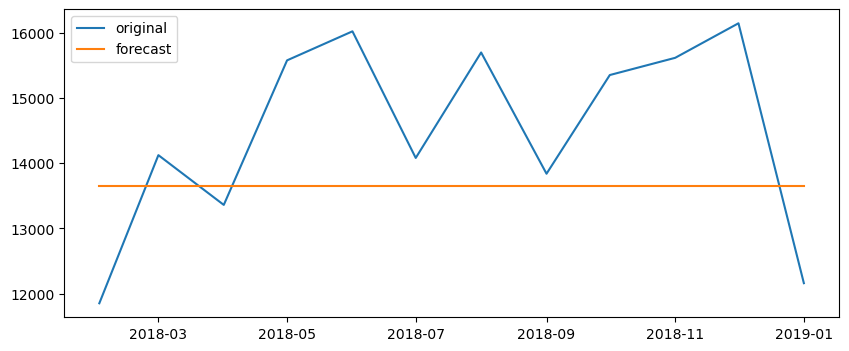

In [66]:
## Simple Exponential Smoothing
# -> level value is calculated from all the past data.
# <Step 1> Calculate prediction values for known Data.
# <Step 2> Forecast for unknown test Data.

# Forecast value is same for all future Data points y(t+1), y(t+2), t(t+3) ... = yPred(t)

###########################################################
#      Grid Search for hyperParameter Tuning              #
###########################################################
model = sm_api.tsa.SimpleExpSmoothing(endog=train["Sales"])
bestMape = 100
bestSM = 0
bestFitModel = None
for smFactor in np.linspace(0.1, 1, 100):
    fitModel = model.fit(smoothing_level=smFactor)
    mape = mean_absolute_percentage_error(test["Sales"], fitModel.forecast(steps=12))
    if mape < bestMape:
        bestMape = mape
        bestSM = smFactor
        bestFitModel = fitModel
print("Best MAPE: {}, Best Smoothing Factor = {}".format(bestMape, bestSM))

print()
print("TRAIN ACCURACY: ")
eval_model(train["Sales"], bestFitModel.fittedvalues)
print()
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=bestFitModel.forecast(steps=12))
print()

plt.plot(test["Sales"], label="original")
plt.plot(bestFitModel.forecast(steps=12), label="forecast")
plt.legend()
plt.show()

TRAIN ACCURACY: 
MAPE:  10.331
MAE:   1062.517
RMSE:  1478.793

TEST ACCURACY:
MAPE:  11.343
MAE:   1697.521
RMSE:  1928.131



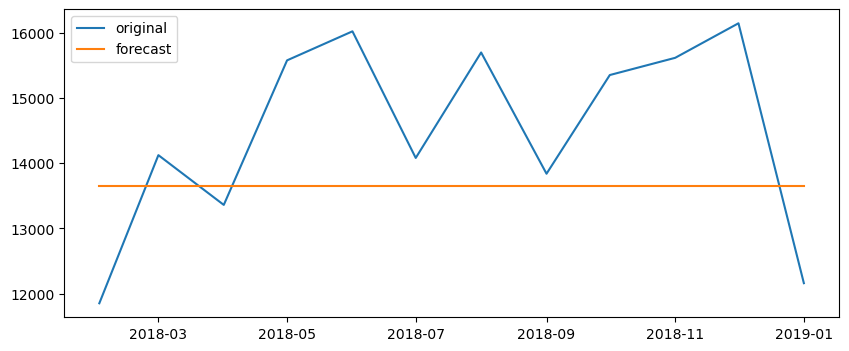

In [67]:
###########################################################
#              Theoritical hyperParameter                 #
###########################################################
model = sm_api.tsa.SimpleExpSmoothing(endog=train["Sales"]).fit(smoothing_level=(1/24))
# finding the MAPE for training data
print("TRAIN ACCURACY: ")
eval_model(train["Sales"], fitModel.fittedvalues)
print()
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=model.forecast(steps=12))
print()

plt.plot(test["Sales"], label="original")
plt.plot(bestFitModel.forecast(steps=12), label="forecast")
plt.legend()
plt.show()

Testing accuracy is <span style="color:Green"> **11.343%** </span> MAPE <br>
Training accuracy is <span style="color:Green"> **10.331%** </span> MAPE <br>

Both the Training and Test Accuracies are Good. <br>
We can see that the best smoothing level( aplha ) is 0.1363



In [68]:
## Double Exponential Smoothing
# Level and Trend are both considered.
# We can have multiple Trends which will have its own weights.
# <Step 1> Calculate prediction values for known Data.
# <Step 2> Forecast for unknown test Data.

# Forecast value is same for all future Data points yPred(t+h) = yPred(t) + (steps * bt)

###########################################################
#      Grid Search for hyperParameter Tuning              #
###########################################################
model = sm_api.tsa.ExponentialSmoothing(endog=train["Sales"], trend="add")
bestMape = 100
bestSM = 0
bestFitModel = None
for smFactor in np.linspace(0.1, 1, 100):
    fitModel = model.fit(smoothing_level=smFactor)
    mape = mean_absolute_percentage_error(test["Sales"], fitModel.forecast(steps=12))
    if mape < bestMape:
        bestMape = mape
        bestSM = smFactor
        bestFitModel = fitModel

print("Best MAPE: {}, Best Smoothing Factor = {}".format(bestMape, bestSM))

Best MAPE: 0.08592447497041804, Best Smoothing Factor = 0.1


TRAIN Accuracy: 
MAPE:  8.733
MAE:   903.703
RMSE:  1209.162

TEST ACCURACY:
MAPE:  8.592
MAE:   1223.945
RMSE:  1421.933



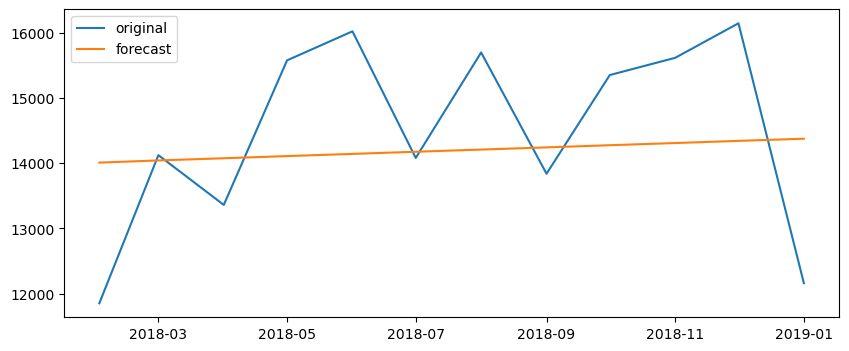

In [69]:
# finding the MAPE for training data
print("TRAIN Accuracy: ")
eval_model(train["Sales"], bestFitModel.fittedvalues)
print()
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=bestFitModel.forecast(steps=12))
print()

plt.plot(test["Sales"], label="original")
plt.plot(bestFitModel.forecast(steps=12), label="forecast")
plt.legend()
plt.show()

Testing accuracy is <span style="color:Green"> **8.592%** </span> MAPE <br>
Training accuracy is <span style="color:Green"> **8.733%** </span> MAPE <br>

Both the Training and Test Accuracies are Good. <br>
We can see that the best smoothing level( aplha ) is 0.1363

In [70]:
## Triple Exponential Smoothing
# Level and Trend, Seasonality are all considered.
# We can have multiple Trends which will have its own weights.
# <Step 1> Calculate prediction values for known Data.
# <Step 2> Forecast for unknown test Data.

# Forecast value is same for all future Data points yPred(t+h) = yPred(t) + (steps * bt) + S(t + step - Seasonality)

###########################################################
#      Grid Search for hyperParameter Tuning              #
###########################################################
model = sm_api.tsa.ExponentialSmoothing(endog=train["Sales"], trend="add", seasonal="add")
bestMape = 100
bestSM = 0
bestFitModel = None
for smFactor in np.linspace(0.1, 1, 100):
    fitModel = model.fit(smoothing_level=smFactor)
    mape = mean_absolute_percentage_error(test["Sales"], fitModel.forecast(steps=12))
    if mape < bestMape:
        bestMape = mape
        bestSM = smFactor
        bestFitModel = fitModel
print("Best MAPE: {}, Best Smoothing Factor = {}".format(bestMape, bestSM))

Best MAPE: 0.04163687511679471, Best Smoothing Factor = 0.1


Best MAPE: 0.04163687511679471, Best Smoothing Factor = 0.1

TRAIN Accuracy: 
MAPE:  4.366
MAE:   471.088
RMSE:  683.735

TEST ACCURACY:
MAPE:  4.164
MAE:   617.768
RMSE:  768.619



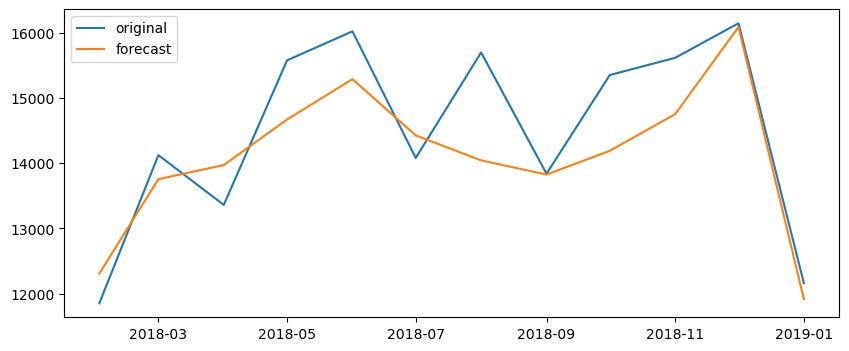

In [71]:
# finding the MAPE for training data
print("Best MAPE: {}, Best Smoothing Factor = {}".format(bestMape, bestSM))
print()
print("TRAIN Accuracy: ")
eval_model(train["Sales"], bestFitModel.fittedvalues)
print()
print("TEST ACCURACY:")
eval_model(yVal=test["Sales"], yPred=bestFitModel.forecast(steps=12))
print()

plt.plot(test["Sales"], label="original")
plt.plot(bestFitModel.forecast(steps=12), label="forecast")
plt.legend()
plt.show()

Testing accuracy is <span style="color:Green"> **4.366%** </span> MAPE <br>
Training accuracy is <span style="color:Green"> **4.164%** </span> MAPE <br>

Both the Training and Test Accuracies are Good. <br>
We can see that the best smoothing level( aplha ) is 0.1

# SARIMAX Modeling

## Stationarity

In [115]:
def stationarityTest(dataName, data):
    pValue = sm_api.tsa.stattools.adfuller(data.dropna())[1]
    if pValue < 0.05:
        print(dataName, " DATA: is Stationary. pValue:", pValue)
    else:
        print(dataName, " DATA: is NOT Stationary. pValue:", pValue)

In [116]:
# Augmented Dicky Fuller Test -- To test the Stationarity
trainStat = train["Sales"] - train["Sales"].shift(1)
testStat  = test["Sales"] - test["Sales"].shift(1)
stationarityTest(dataName="TRAIN", data=trainStat)
stationarityTest(dataName="TEST", data=testStat)

TRAIN  DATA: is Stationary. pValue: 4.588229184400229e-14
TEST  DATA: is Stationary. pValue: 0.0008296986312105992


The pValue is less than 0.05, So the Data can be confirmed to be Stationary. 

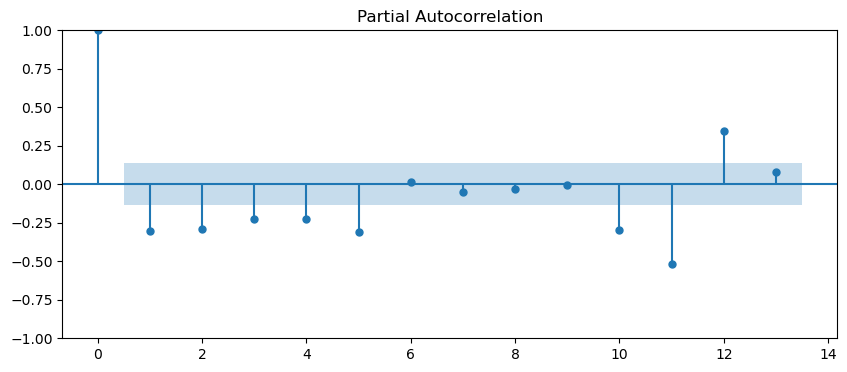

In [133]:
# PACF for AR model
sm_api.tsa.graphics.plot_pacf(x=trainStat.dropna(), lags=13)
plt.show()

We can see that, 4 lag values have Direct Correlation and can be used for forecast

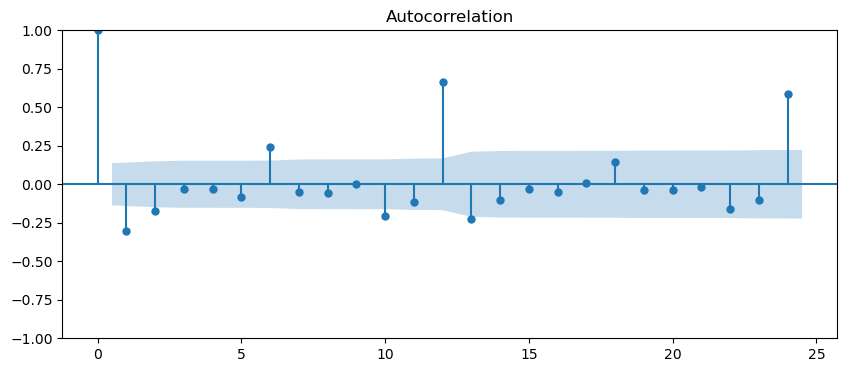

In [134]:
# ACF plot for MA model
sm_api.tsa.graphics.plot_acf(x=trainStat.dropna())
plt.show()

We can see that, lag-6, lag-12 have a direct + indirect Correlation.
We can say that the major Seasonality value = 12, and minor seasonality = 6

## AR - AutoRegression Model

Best MAPE: 0.059989142744199676, Best order = 11
TEST ACCURACY:
MAPE:  5.999
MAE:   900.755
RMSE:  1208.003


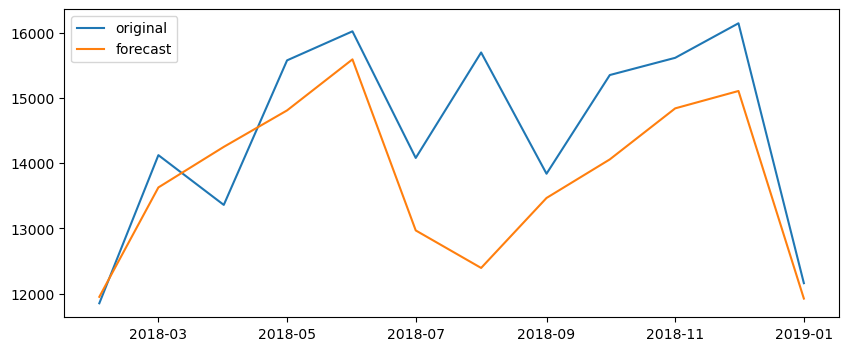

In [162]:
# Use past 5 lag values to Predict the future value
bestMape = 100
bestP = 0
bestFitModel = None
for p in range(1, 20):
    model = sm_api.tsa.statespace.SARIMAX(endog=trainStat, order=(p,0,0))
    modelFit = model.fit(disp=False)
    pred = train["Sales"].iloc[-1] + modelFit.forecast(steps=12).cumsum()
    mape = mean_absolute_percentage_error(y_true=test["Sales"], y_pred=pred)
    if mape < bestMape:
        bestMape = mape
        bestP = p
        bestFitModel = modelFit

# finding the MAPE for training data
print("Best MAPE: {}, Best order = {}".format(bestMape, bestP))
print("TEST ACCURACY:")
pred = train["Sales"].iloc[-1] + bestFitModel.forecast(steps=12).cumsum()
eval_model(yVal=test["Sales"], yPred=pred)

plt.plot(test["Sales"], label="original")
plt.plot(pred, label="forecast")
plt.legend()
plt.show()

## Moving Average Model